# Model 2: Dynamic  Revenue  Maximization

This  model  builds  on  the  baseline  by 
introducing a multi-round time horizon to assess long-term planning, changing the objective to 
maximizing total revenue. It adds dynamic elements to simulate market changes, such as a 
constant growth in demand. This creates a dynamic financial situation where revenue streams 
must be managed to fund investments, forcing players to plan around an evolving budget rather 
than a static one

##### Notebook Outline
1) Imports
2) Load Input Data
3) Scenario Parameters
4) Gurobi Model Setup
5) Results
6) Visualizations

### Imports

In [1]:
import json
from pathlib import Path
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

### Load input data

In [2]:
# technology data
data_path = Path("data") / "technology_data.json"

with data_path.open("r", encoding="utf-8") as f:
    technology_data = json.load(f)

TECHNOLOGY_UNITS = technology_data["TECHNOLOGY_UNITS"]  
TECHNOLOGY_DATA = technology_data["TECHNOLOGY_DATA"]

df_units = pd.DataFrame(list(TECHNOLOGY_UNITS.items()), columns=["Parameter", "Unit"])
df_tech = pd.DataFrame(TECHNOLOGY_DATA).reset_index().rename(columns={"index": "parameter"})
df = df_units.merge(df_tech, left_on="Parameter", right_on="parameter", how="right").drop(columns=["parameter"])
print("Technology Data:")
display(df)

# load electricity prices
price_data_path = Path("data") / "electricity_prices.xlsx"
df_prices = pd.read_excel(price_data_path)[["Year", "Price"]].iloc[:20]
df_prices["Year"] = df_prices["Year"].astype(int)
df_prices["Price"] = df_prices["Price"].astype(float)

exchange_rate = 7.4 # DKK to EUR
df_prices["Price"] = df_prices["Price"]/exchange_rate
price_list = df_prices["Price"].tolist()

df_display = df_prices.T
df_display.columns = df_prices["Year"].tolist()
df_display = df_display.drop("Year")
print("Electricity Prices (EUR/MWh):")
display(df_display)

Technology Data:


,Parameter,Unit,Gas turbine (simple cycle),Natural gas engine plant,Diesel engine farm,OCGT - Natural gas,Coal power plant,Nuclear power plant,Onshore wind,Offshore wind (fixed),Utility-scale PV
0,nominal_investment_total,MEUR/MW_el,0.600,0.50,0.36,0.47,2.10,4.000,1.150,2.390,0.38
1,fixed_om_total,EUR/MW/year,19778.730,6646.08,8983.37,8236.12,34324.40,147700.000,16663.000,34000.000,9500.00
2,variable_om_total,EUR/MWh,4.470,6.38,6.38,4.79,3.21,20.000,0.000,0.000,0.00
3,elec_eff,fraction (0-1),0.410,0.48,0.35,0.41,0.52,0.360,0.410,0.520,0.16
4,technical_lifetime,years,25.000,25.00,25.00,25.00,25.00,60.000,30.000,30.000,35.00
5,construction_time,years,1.500,1.00,1.00,0.20,4.50,8.000,1.500,3.500,0.50
6,total_outage,fraction of time (0-1),0.025,0.01,0.01,0.01,0.00,0.001,0.023,0.025,NaN


Electricity Prices (EUR/MWh):


,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044
Price,90.598127,88.152135,83.576931,82.826762,80.538427,79.397276,74.590121,67.366515,64.427126,62.897569,58.468283,59.1168,59.890278,60.807289,61.886407,63.146206,64.605259,66.28214,68.195421,70.363677


### Scenario Parameters

In [3]:
market_share = 0.35                               
num_periods = 20
time_periods = list(range(num_periods))
hours_per_year = 8760

initial_budget = 100                              # MEUR
base_demand = market_share * 35_250_000           # MWh
demand_growth_rate = 0.02                         # yearly growth

# Maximum cumulative installed capacity per tech (MW)
max_capacity = {
    "Gas turbine (simple cycle)": market_share*1500,
    "Natural gas engine plant":   market_share*1500,
    "Diesel engine farm":         market_share*100,
    "OCGT - Natural gas":         market_share*2000,
    "Coal power plant":           market_share*1500,
    "Nuclear power plant":        market_share*1000,
    "Onshore wind":               market_share*3500,
    "Offshore wind (fixed)":      market_share*5000,
    "Utility-scale PV":           market_share*4000,
}

#### Preprocessing - build parameter dictionaries

In [4]:
tech_names = list(TECHNOLOGY_DATA.keys())

# --- Technical & economic parameters ---
capex = {tech: TECHNOLOGY_DATA[tech]['nominal_investment_total']
         for tech in tech_names}

elec_eff = {tech: TECHNOLOGY_DATA[tech]['elec_eff']
            for tech in tech_names}

vom_eur = {tech: TECHNOLOGY_DATA[tech]['variable_om_total']
           for tech in tech_names}

vom_meur = {tech: vom_eur[tech] / 1e6
            for tech in tech_names}

fixed_om_eur = {tech: TECHNOLOGY_DATA[tech]['fixed_om_total']
                for tech in tech_names}

fixed_om_meur = {tech: fixed_om_eur[tech] / 1e6
                 for tech in tech_names}

# --- Prices ---
price_eur = {t: price_list[t] for t in time_periods}
price_meur = {t: price_eur[t] / 1e6 for t in time_periods}

# --- Demand curve ---
demand = {
    t: base_demand * ((1 + demand_growth_rate) ** t)
    for t in time_periods
}

### Gurobi Model Setup

#### Variables

In [5]:
model = gp.Model("Dynamic_Revenue_Maximization")

# Investment in new capacity [MW] in period t
investment = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Investment"
)

# Available capacity [MW] in period t (accumulated)
capacity = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Capacity"
)

# Energy produced [MWh] by tech in period t
energy = model.addVars(
    tech_names, time_periods,
    vtype=GRB.CONTINUOUS,
    name="Energy"
)

# Budget available in each period [MEUR]
budget = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="Budget"
)

# Auxiliary variables for accounting
revenue = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="Revenue"
)

# O&M and CAPEX costs
op_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="OperatingCost"
)

fixed_om_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="FixedOMCost"
)

capex_cost = model.addVars(
    time_periods,
    vtype=GRB.CONTINUOUS,
    name="CapexCost"
)

Set parameter Username
Set parameter LicenseID to value 2626572
Academic license - for non-commercial use only - expires 2026-02-22


#### Model constraints

In [6]:
# Capacity accumulation
for tech in tech_names:
    model.addConstr(capacity[tech, 0] == investment[tech, 0])
    for t in time_periods[1:]:
        model.addConstr(
            capacity[tech, t] == capacity[tech, t-1] + investment[tech, t],
            name=f"CapacityAccum_{tech}_{t}"
        )

# Cumulative capacity limits
for tech in tech_names:
    if tech in max_capacity:
        for t in time_periods:
            model.addConstr(
                capacity[tech, t] <= max_capacity[tech],
                name=f"MaxCap_{tech}_{t}"
            )

# Production limited by capacity * efficiency * hours
for tech in tech_names:
    for t in time_periods:
        model.addConstr(
            energy[tech, t] <= capacity[tech, t] * elec_eff[tech] * hours_per_year,
            name=f"ProdCap_{tech}_{t}"
        )

# Define revenue, OPEX, CAPEX, fixed O&M
for t in time_periods:
    model.addConstr(
        revenue[t] == gp.quicksum(energy[tech, t] * price_meur[t] for tech in tech_names),
        name=f"RevenueDef_{t}"
    )

    model.addConstr(
        op_cost[t] == gp.quicksum(energy[tech, t] * vom_meur[tech] for tech in tech_names),
        name=f"OpCostDef_{t}"
    )

    model.addConstr(
        capex_cost[t] == gp.quicksum(investment[tech, t] * capex[tech] for tech in tech_names),
        name=f"CapexCostDef_{t}"
    )

    model.addConstr(
        fixed_om_cost[t] == gp.quicksum(capacity[tech, t] * fixed_om_meur[tech] for tech in tech_names),
        name=f"FixedOMDef_{t}"
    )

# Budget dynamics
model.addConstr(budget[0] == initial_budget)

for t in time_periods:
    # Cannot invest more than available budget
    model.addConstr(capex_cost[t] <= budget[t], name=f"InvLimit_{t}")
    model.addConstr(budget[t] >= 0, name=f"BudgetNonNeg_{t}")

    if t < num_periods - 1:
        model.addConstr(
            budget[t+1] == budget[t] - capex_cost[t] + revenue[t] - op_cost[t] - fixed_om_cost[t],
            name=f"BudgetDyn_{t}"
        )

# Demand cap
for t in time_periods:
    model.addConstr(
        gp.quicksum(energy[tech, t] for tech in tech_names) <= demand[t],
        name=f"DemandCap_{t}"
    )

#### Objective Function + optimize

In [7]:
model.setObjective(
    gp.quicksum(
        revenue[t] - op_cost[t] - fixed_om_cost[t] - capex_cost[t]
        for t in time_periods
    ),
    GRB.MAXIMIZE
)
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 700 rows, 640 columns and 2166 nonzeros
Model fingerprint: 0xc073d663
Coefficient statistics:
  Matrix range     [3e-06, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 2e+07]
Presolve removed 462 rows and 243 columns
Presolve time: 0.03s
Presolved: 238 rows, 397 columns, 2072 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.1671779e+04   2.538343e+06   0.000000e+00      0s
     718    9.1727629e+03   0.000000e+00   0.000000e+00      0s

Solved in 718 iterations and 0.05 seconds (0.01 work units)
Optimal objective  9.172762872e+03


#### Results

In [8]:
if model.status != GRB.OPTIMAL:
    print(f"Model did not solve to optimality. Status: {model.status}")

else:
    print("Optimal solution found.\n")

    budget_df = pd.DataFrame({
        t: [budget[t].X]
        for t in time_periods
    }, index=["Budget (MEUR)"])

    print("---- Budget Evolution (MEUR) ----")
    display(budget_df)
    print()

    rev_cost_df = pd.DataFrame({
        t: {
            "Revenue (MEUR)":     revenue[t].X,
            "Var OPEX (MEUR)":    op_cost[t].X,
            "Fixed OPEX (MEUR)":  fixed_om_cost[t].X,
            "CAPEX (MEUR)":       capex_cost[t].X,
            "Net Cash Flow":      revenue[t].X - op_cost[t].X - capex_cost[t].X - fixed_om_cost[t].X
        }
        for t in time_periods
    })

    print("---- Revenue & Costs per Period (MEUR) ----")
    display(rev_cost_df)
    print()

    capacity_df = pd.DataFrame({
        t: {tech: capacity[tech, t].X for tech in tech_names}
        for t in time_periods
    })

    capacity_df.index.name = "Technology"

    capacity_df.loc["Total"] = capacity_df.sum(axis=0)

    print("---- Installed Capacity (MW) ----")
    display(capacity_df)
    print()

    production_df = pd.DataFrame({
        t: {tech: energy[tech, t].X/1e3 for tech in tech_names}
        for t in time_periods
    })

    production_df.index.name = "Technology"
    production_df.loc["Total"] = production_df.sum(axis=0)

    print("---- Energy Production (GWh) ----")
    display(production_df)
    print()

    totals_df = pd.DataFrame({
        "Total Revenue":      [sum(revenue[t].X for t in time_periods)],
        "Total Variable OPEX":[sum(op_cost[t].X for t in time_periods)],
        "Total Fixed OPEX":   [sum(fixed_om_cost[t].X for t in time_periods)],
        "Total CAPEX":        [sum(capex_cost[t].X for t in time_periods)],
        "Final Budget":       [budget[num_periods-1].X]
    })

    print("---- TOTALS OVER ALL PERIODS ----")
    display(totals_df)

Optimal solution found.

---- Budget Evolution (MEUR) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Budget (MEUR),100.0,69.49486,114.303738,179.978864,282.366055,412.532384,542.094164,633.253704,689.000918,772.576597,987.363257,1620.744555,2275.709715,3081.206354,3900.770062,4736.887587,5592.330591,6470.15566,7373.704296,8306.60292



---- Revenue & Costs per Period (MEUR) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Revenue (MEUR),76.189401,125.650641,199.021922,311.150903,457.395647,603.276126,705.363879,770.286664,865.284596,927.390345,879.324606,906.859433,918.724677,932.791747,949.345562,968.671043,991.053107,1016.776674,1046.126662,1079.387990
Var OPEX (MEUR),5.365325,9.093950,15.087017,21.674919,30.611968,35.239837,35.239837,35.239837,36.376014,40.594004,41.540598,42.506124,42.506124,42.506124,42.506124,42.506124,42.506124,42.506124,42.506124,42.506124
Fixed OPEX (MEUR),1.329216,2.252953,3.956041,7.109930,14.251295,25.942125,36.870338,46.045909,56.331985,66.233370,68.455422,70.721915,70.721915,70.721915,70.721915,70.721915,70.721915,70.721915,70.721915,70.721915
CAPEX (MEUR),100.000000,69.494860,114.303738,179.978864,282.366055,412.532384,542.094164,633.253704,689.000918,605.776311,135.947289,138.666235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Net Cash Flow,-30.505140,44.808878,65.675126,102.387191,130.166329,129.561780,91.159540,55.747214,83.575679,214.786661,633.381298,654.965160,805.496638,819.563708,836.117524,855.443005,877.825069,903.548636,932.898624,966.159952



---- Installed Capacity (MW) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Technology,,,,,,,,,,,,,,,,,,,,
Gas turbine (simple cycle),0.0,0.000000,0.000000,0.00000,236.739196,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000
Natural gas engine plant,200.0,338.989721,525.000000,525.00000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000
Diesel engine farm,0.0,0.000000,35.000000,35.00000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
OCGT - Natural gas,0.0,0.000000,18.507656,401.44141,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
Coal power plant,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,77.702232,366.167142,430.903946,496.935487,496.935487,496.935487,496.935487,496.935487,496.935487,496.935487,496.935487,496.935487
Nuclear power plant,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Onshore wind,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,217.104405,767.759799,1225.000000,1225.000000,1225.000000,1225.000000,1225.000000,1225.000000,1225.000000,1225.000000,1225.000000,1225.000000,1225.000000,1225.000000
Offshore wind (fixed),0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Utility-scale PV,0.0,0.000000,0.000000,0.00000,0.000000,630.462899,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000



---- Energy Production (GWh) ----


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Technology,,,,,,,,,,,,,,,,,,,,
Gas turbine (simple cycle),0.00,0.000000,0.000000,0.000000,850.272496,1885.5900,1885.590000,1885.590000,1885.590000,1885.590000,1885.590000,1885.59000,1885.59000,1885.59000,1885.59000,1885.59000,1885.59000,1885.59000,1885.59000,1885.59000
Natural gas engine plant,840.96,1425.383977,2207.520000,2207.520000,2207.520000,2207.5200,2207.520000,2207.520000,2207.520000,2207.520000,2207.520000,2207.52000,2207.52000,2207.52000,2207.52000,2207.52000,2207.52000,2207.52000,2207.52000,2207.52000
Diesel engine farm,0.00,0.000000,107.310000,107.310000,107.310000,107.3100,107.310000,107.310000,107.310000,107.310000,107.310000,107.31000,107.31000,107.31000,107.31000,107.31000,107.31000,107.31000,107.31000,107.31000
OCGT - Natural gas,0.00,0.000000,66.472099,1441.816968,2514.120000,2514.1200,2514.120000,2514.120000,2514.120000,2514.120000,2514.120000,2514.12000,2514.12000,2514.12000,2514.12000,2514.12000,2514.12000,2514.12000,2514.12000,2514.12000
Coal power plant,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,353.949207,1667.964565,1962.853657,2263.64053,2263.64053,2263.64053,2263.64053,2263.64053,2263.64053,2263.64053,2263.64053,2263.64053
Nuclear power plant,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Onshore wind,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,779.752181,2757.486096,4399.710000,4399.710000,4399.710000,4399.71000,4399.71000,4399.71000,4399.71000,4399.71000,4399.71000,4399.71000,4399.71000,4399.71000
Offshore wind (fixed),0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Utility-scale PV,0.00,0.000000,0.000000,0.000000,0.000000,883.6568,1962.240000,1962.240000,1962.240000,1962.240000,1962.240000,1962.24000,1962.24000,1962.24000,1962.24000,1962.24000,1962.24000,1962.24000,1962.24000,1962.24000



---- TOTALS OVER ALL PERIODS ----


,Total Revenue,Total Variable OPEX,Total Fixed OPEX,Total CAPEX,Final Budget
0,14730.071626,688.618419,965.275813,3903.414522,8306.60292


#### Visualizations

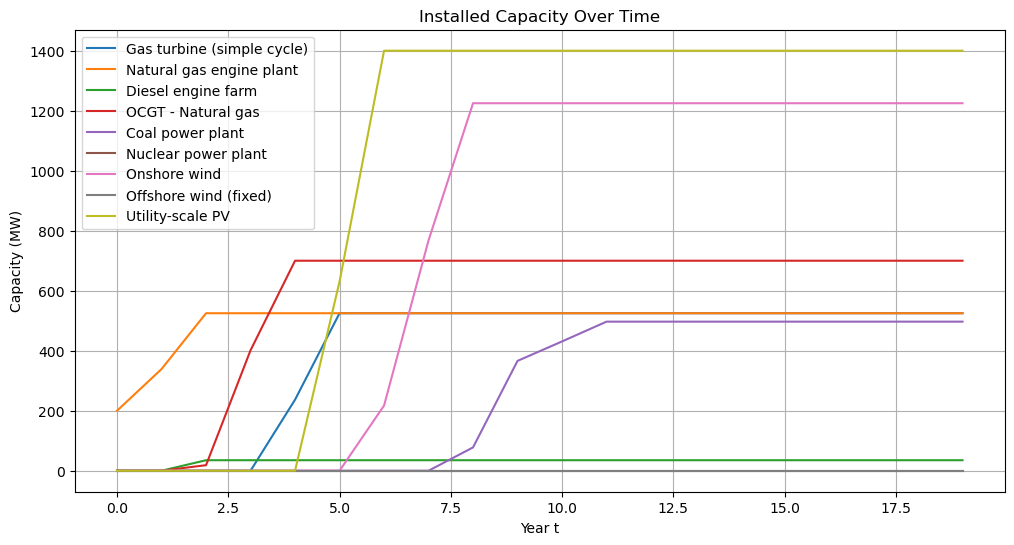

In [22]:
import matplotlib.pyplot as plt

# Build dataframe-like structure
cap_plot = {tech: [capacity[tech,t].X for t in time_periods] 
            for tech in tech_names}

plt.figure(figsize=(12,6))
for tech, vals in cap_plot.items():
    plt.plot(time_periods, vals, label=tech)

plt.title("Installed Capacity Over Time")
plt.xlabel("Year t")
plt.ylabel("Capacity (MW)")
plt.legend()
plt.grid(True)
plt.show()

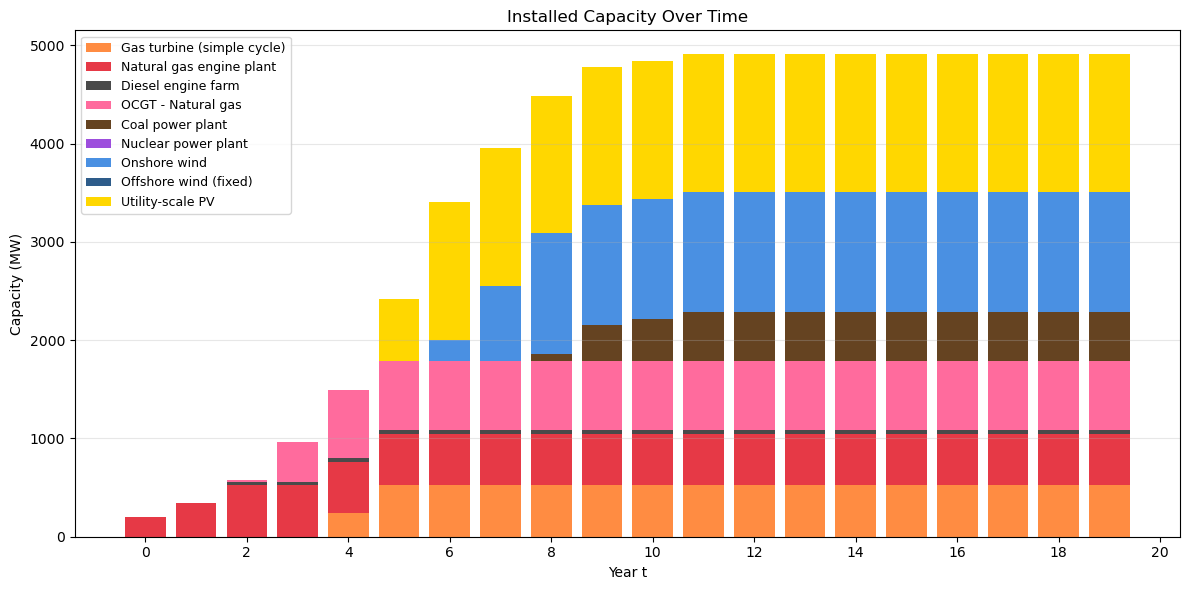

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Build dataframe-like structure
cap_plot = {tech: [capacity[tech,t].X for t in time_periods] 
            for tech in tech_names}

# Define intuitive colors for each technology
tech_colors = {
    'Gas turbine (simple cycle)': '#FF8C42',      # Orange (gas)
    'Natural gas engine plant': '#E63946',        # Red (gas)
    'Diesel engine farm': '#4A4A4A',              # Dark gray (diesel/oil)
    'OCGT - Natural gas': '#FF6B9D',              # Pink (gas)
    'Coal power plant': '#654321',                # Brown (coal)
    'Nuclear power plant': '#9D4EDD',             # Purple (nuclear)
    'Onshore wind': '#4A90E2',                    # Blue (wind)
    'Offshore wind (fixed)': '#2E5C8A',           # Dark blue (wind)
    'Utility-scale PV': '#FFD700',                # Yellow/gold (solar)
}

plt.figure(figsize=(12,6))
display_periods = [t + 1 for t in time_periods]

# Prepare data for stacking
bottom = np.zeros(len(time_periods))

for tech, vals in cap_plot.items():
    color = tech_colors.get(tech, '#CCCCCC')  # Default gray if not found
    plt.bar(display_periods, vals, label=tech, bottom=bottom, color=color)
    bottom += np.array(vals)  # Stack next bars on top

plt.title("Installed Capacity Over Time")
plt.xlabel("Year t")
plt.xticks(range(0, 21, 2))
plt.ylabel("Capacity (MW)")
plt.legend(fontsize=9)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

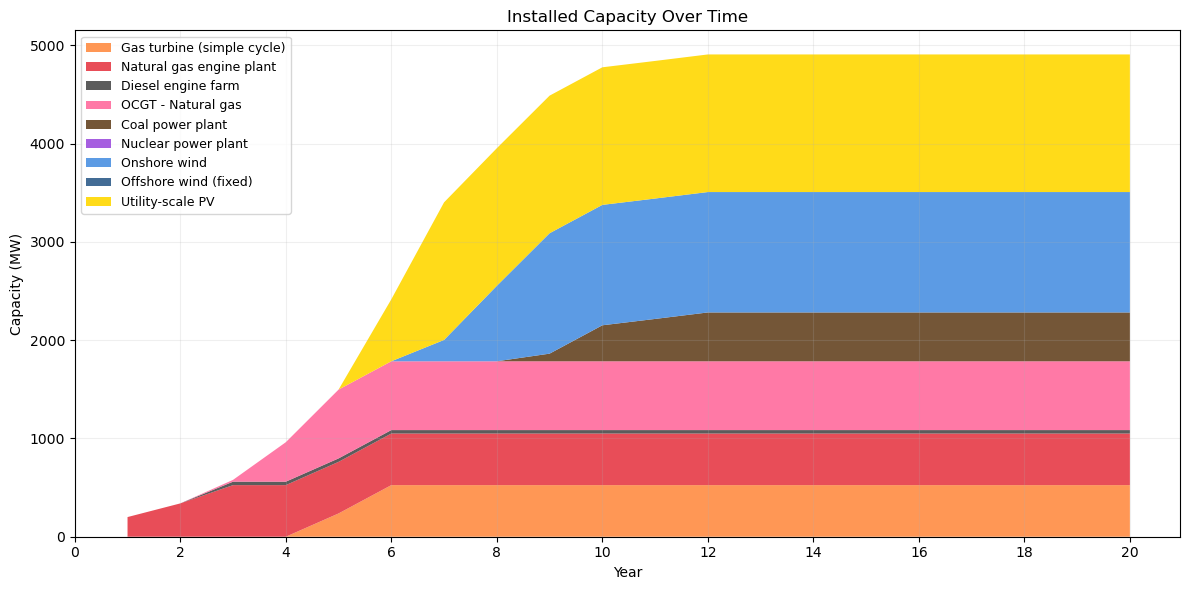

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Build dataframe-like structure
cap_plot = {tech: [capacity[tech,t].X for t in time_periods] 
            for tech in tech_names}

# Define intuitive colors for each technology
tech_colors = {
    'Gas turbine (simple cycle)': '#FF8C42',      # Orange (gas)
    'Natural gas engine plant': '#E63946',        # Red (gas)
    'Diesel engine farm': '#4A4A4A',              # Dark gray (diesel/oil)
    'OCGT - Natural gas': '#FF6B9D',              # Pink (gas)
    'Coal power plant': '#654321',                # Brown (coal)
    'Nuclear power plant': '#9D4EDD',             # Purple (nuclear)
    'Onshore wind': '#4A90E2',                    # Blue (wind)
    'Offshore wind (fixed)': '#2E5C8A',           # Dark blue (wind)
    'Utility-scale PV': '#FFD700',                # Yellow/gold (solar)
}

plt.figure(figsize=(12,6))

display_periods = [t + 1 for t in time_periods]

# Convert to arrays for stackplot
tech_list = list(cap_plot.keys())
values = [cap_plot[tech] for tech in tech_list]
colors = [tech_colors.get(tech, '#CCCCCC') for tech in tech_list]

# Create stacked area plot
plt.stackplot(display_periods, values, labels=tech_list, colors=colors, alpha=0.9)

plt.title("Installed Capacity Over Time")
plt.xlabel("Year")
plt.xticks(range(0, 21, 2))
plt.ylabel("Capacity (MW)")
plt.legend(loc='upper left', fontsize=9)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

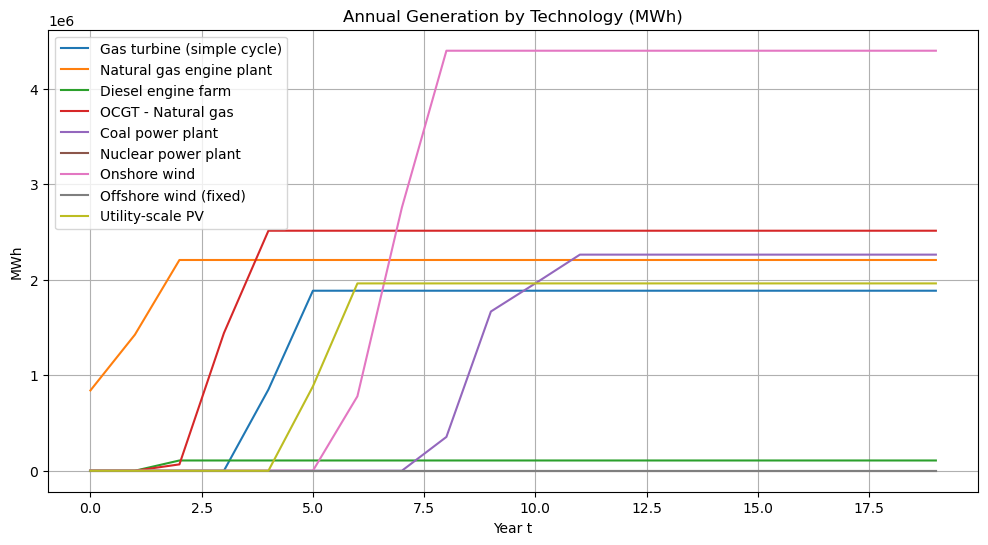

In [10]:
gen_plot = {tech: [energy[tech,t].X for t in time_periods]
            for tech in tech_names}

plt.figure(figsize=(12,6))
for tech, vals in gen_plot.items():
    plt.plot(time_periods, vals, label=tech)

plt.title("Annual Generation by Technology (MWh)")
plt.xlabel("Year t")
plt.ylabel("MWh")
plt.legend()
plt.grid(True)
plt.show()

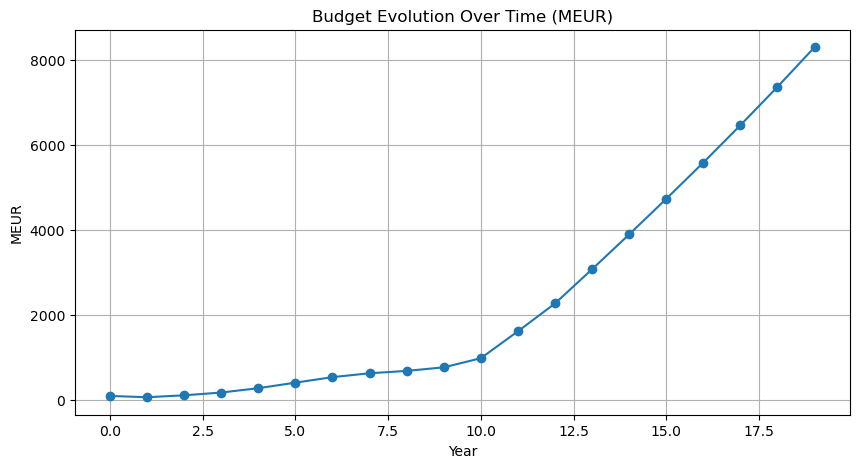

In [11]:
bud = [budget[t].X for t in time_periods]

plt.figure(figsize=(10,5))
plt.plot(time_periods, bud, marker="o")
plt.title("Budget Evolution Over Time (MEUR)")
plt.xlabel("Year")
plt.ylabel("MEUR")
plt.grid(True)
plt.show()

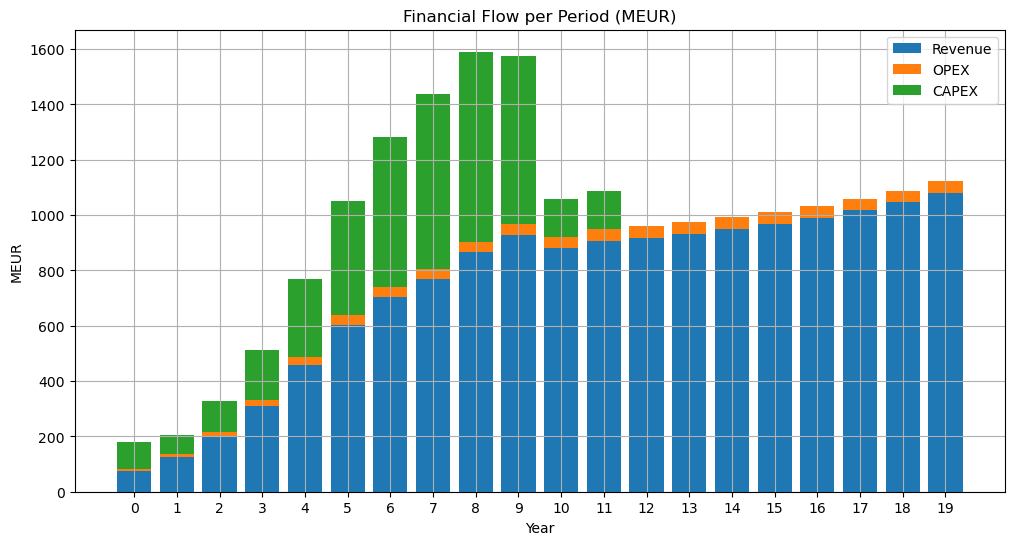

In [12]:
import numpy as np

rev = [revenue[t].X for t in time_periods]
op  = [op_cost[t].X for t in time_periods]
cap = [capex_cost[t].X for t in time_periods]

x = np.arange(len(time_periods))

plt.figure(figsize=(12,6))
plt.bar(x, rev, label="Revenue")
plt.bar(x, op, bottom=rev, label="OPEX")
plt.bar(x, cap, bottom=np.array(rev)+np.array(op), label="CAPEX")

plt.xticks(x, time_periods)
plt.title("Financial Flow per Period (MEUR)")
plt.xlabel("Year")
plt.ylabel("MEUR")
plt.legend()
plt.grid(True)
plt.show()

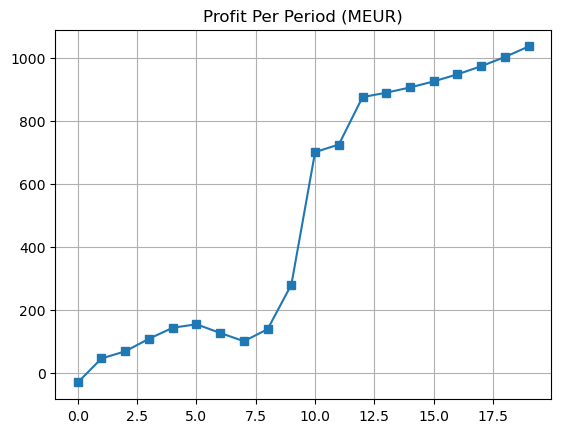

In [13]:
profit_t = [revenue[t].X - op_cost[t].X - capex_cost[t].X 
            for t in time_periods]

plt.plot(time_periods, profit_t, marker="s")
plt.title("Profit Per Period (MEUR)")
plt.grid(True)
plt.show()

#### Model Duals

In [14]:
for t in time_periods:
    constr = model.getConstrByName(f"DemandCap_{t}")
    print(f"Dual Demand Cap t={t}: {constr.Pi:.4f}")

Dual Demand Cap t=0: 0.0000
Dual Demand Cap t=1: 0.0000
Dual Demand Cap t=2: 0.0000
Dual Demand Cap t=3: 0.0000
Dual Demand Cap t=4: 0.0000
Dual Demand Cap t=5: 0.0000
Dual Demand Cap t=6: 0.0000
Dual Demand Cap t=7: 0.0000
Dual Demand Cap t=8: 0.0000
Dual Demand Cap t=9: 0.0001
Dual Demand Cap t=10: 0.0000
Dual Demand Cap t=11: 0.0000
Dual Demand Cap t=12: 0.0000
Dual Demand Cap t=13: 0.0000
Dual Demand Cap t=14: 0.0000
Dual Demand Cap t=15: 0.0000
Dual Demand Cap t=16: 0.0000
Dual Demand Cap t=17: 0.0000
Dual Demand Cap t=18: 0.0000
Dual Demand Cap t=19: 0.0000


In [15]:
for tech in tech_names:
    for t in time_periods:
        c = model.getConstrByName(f"MaxCapacity_{tech}_{t}")
        if c is not None and abs(c.Pi) > 1e-6:
            print(f"{tech}, t={t}: shadow price = {c.Pi}")

In [16]:
for t in time_periods:
    c = model.getConstrByName(f"InvLimit_{t}")   # capex_cost[t] <= budget[t]
    print(f"Shadow price investment limit t{t}: {c.Pi:.4f}")

Shadow price investment limit t0: 8.5403
Shadow price investment limit t1: 4.9496
Shadow price investment limit t2: 2.7076
Shadow price investment limit t3: 1.6981
Shadow price investment limit t4: 0.8712
Shadow price investment limit t5: 0.4358
Shadow price investment limit t6: 0.2917
Shadow price investment limit t7: 0.2187
Shadow price investment limit t8: 0.1164
Shadow price investment limit t9: 0.0000
Shadow price investment limit t10: 0.0000
Shadow price investment limit t11: 0.0000
Shadow price investment limit t12: 0.0000
Shadow price investment limit t13: 0.0000
Shadow price investment limit t14: 0.0000
Shadow price investment limit t15: 0.0000
Shadow price investment limit t16: 0.0000
Shadow price investment limit t17: 0.0000
Shadow price investment limit t18: 0.0000
Shadow price investment limit t19: 0.0000


In [17]:
for t in time_periods[:-1]:
    c = model.getConstrByName(f"BudgetDyn_{t}")
    print(f"Shadow on budget recursion t={t}: {c.Pi:.4f}")

Shadow on budget recursion t=0: 11.2890
Shadow on budget recursion t=1: 6.3395
Shadow on budget recursion t=2: 3.6319
Shadow on budget recursion t=3: 1.9338
Shadow on budget recursion t=4: 1.0626
Shadow on budget recursion t=5: 0.6268
Shadow on budget recursion t=6: 0.3352
Shadow on budget recursion t=7: 0.1164
Shadow on budget recursion t=8: -0.0000
Shadow on budget recursion t=9: -0.0000
Shadow on budget recursion t=10: -0.0000
Shadow on budget recursion t=11: -0.0000
Shadow on budget recursion t=12: -0.0000
Shadow on budget recursion t=13: -0.0000
Shadow on budget recursion t=14: -0.0000
Shadow on budget recursion t=15: -0.0000
Shadow on budget recursion t=16: -0.0000
Shadow on budget recursion t=17: -0.0000
Shadow on budget recursion t=18: -0.0000
